# Capstone Project: Data Loader



In [4]:
# Import the relevant modules to be used later
from __future__ import print_function
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import struct
import sys

try: 
    from urllib.request import urlretrieve 
except ImportError: 
    from urllib import urlretrieve

# Config matplotlib for inline plotting
%matplotlib inline

## Data download

We will download the data onto the local machine. The MNIST database is a standard set of handwritten digits that has been widely used for training and testing of machine learning algorithms. It has a training set of 60,000 images and a test set of 10,000 images with each image being 28 x 28 grayscale pixels. This set is easy to use visualize and train on any computer.

In [16]:
# Functions to load MNIST images and unpack into train and test set.
# - loadData reads image data and formats into a 28x28 long array
# - loadLabels reads the corresponding labels data, 1 for each image
# - load packs the downloaded image and labels data into a combined format to be read later by 
#   CNTK text reader 

#def loadData(src, cimg):
#    print ('Downloading ' + src)
#    gzfname, h = urlretrieve(src, './delete.me')
#    print ('Done.')
#    try:
#        with gzip.open(gzfname) as gz:
#            n = struct.unpack('I', gz.read(4))
#            print(n)
#            # Read magic number.
#           if n[0] != 0x3080000:
#                raise Exception('Invalid file: unexpected magic number.')
#            # Read number of entries.
#            n = struct.unpack('>I', gz.read(4))[0]
#            print(n)
#            if n != cimg:
#                raise Exception('Invalid file: expected {0} entries.'.format(cimg))
#            crow = struct.unpack('>I', gz.read(4))[0]
#            ccol = struct.unpack('>I', gz.read(4))[0]
#            print(str(crow)+","+str(ccol))
#            if crow != 28 or ccol != 28:
#                raise Exception('Invalid file: expected 28 rows/cols per image.')
#            # Read data.
#            res = np.fromstring(gz.read(cimg * crow * ccol), dtype = np.uint8)
#    finally:
#        os.remove(gzfname)
#    return res.reshape((cimg, crow * ccol))

def loadData(src, cimg):
    print(src)

def loadLabels(src, cimg):
    print ('Downloading ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Done.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # Read magic number.
            if n[0] != 0x1080000:
                raise Exception('Invalid file: unexpected magic number.')
            # Read number of entries.
            n = struct.unpack('>I', gz.read(4))
            if n[0] != cimg:
                raise Exception('Invalid file: expected {0} rows.'.format(cimg))
            # Read labels.
            res = np.fromstring(gz.read(cimg), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, 1))

def try_download(dataSrc, labelsSrc, cimg):
    data = loadData(dataSrc, cimg)
    labels = loadLabels(labelsSrc, cimg)
    return np.hstack((data, labels))


# Download the data

In the following code, we use the functions defined above to download and unzip the MNIST data into memory.  The training set has 60000 images while the test set has 10000 images. 

In [17]:
# URLs for the train image and labels data
url_train_image = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
url_train_labels = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
num_train_samples = 60000

print("Downloading train data")
train = try_download(url_train_image, url_train_labels, num_train_samples)


url_test_image = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
url_test_labels = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
num_test_samples = 10000

print("Downloading test data")
test = try_download(url_test_image, url_test_labels, num_test_samples)


Done.
(50855936,)
60000
28,28


C:\Users\victorgl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Done.


C:\Users\victorgl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Done.
(50855936,)
10000
28,28
Done.


# Visualize the data
Here, we use matplotlib to display one of the training images and it's associated label.

Image Label:  6


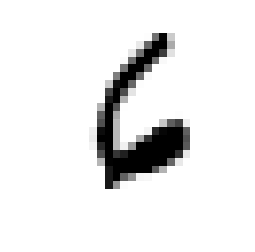

In [18]:
# Plot a random image
sample_number = 5003
plt.imshow(train[sample_number,:-1].reshape(28,28), cmap="gray_r")
plt.axis('off')
print("Image Label: ", train[sample_number,-1])

# Save the images

Save the images in a local directory. While saving the data we flatten the images to a vector (28x28 image pixels becomes an array of length 784 data points).

![mnist-input](https://www.cntk.ai/jup/cntk103a_MNIST_input.png)

The labels are encoded as [1-hot][] encoding (label of 3 with 10 digits becomes `0001000000`, where the first index corresponds to digit `0` and the last one corresponds to digit `9`.

![mnist-label](https://www.cntk.ai/jup/cntk103a_onehot.png)

[1-hot]: https://en.wikipedia.org/wiki/One-hot

In [25]:
# Save the data files into a format compatible with CNTK text reader
def savetxt(filename, ndarray):
    dir = os.path.dirname(filename)

    if not os.path.exists(dir):
        os.makedirs(dir)

    if not os.path.isfile(filename):
        print("Saving", filename )
        with open(filename, 'w') as f:
            labels = list(map(' '.join, np.eye(4, dtype=np.uint).astype(str)))
            for row in ndarray:
                row_str = row.astype(str)
                label_str = labels[row[-1]]
                feature_str = ' '.join(row_str[:-1])
                f.write('|labels {} |features {}\n'.format(label_str, feature_str))
    else:
        print("File already exists", filename)


In [20]:
# Save the train and test files (prefer our default path for the data)
data_dir = os.path.join("..", "Examples", "Image", "DataSets", "MNIST")
if not os.path.exists(data_dir):
    data_dir = os.path.join("data", "MNIST")

print ('Writing train text file...')
savetxt(os.path.join(data_dir, "Train-28x28_cntk_text.txt"), train)

print ('Writing test text file...')
savetxt(os.path.join(data_dir, "Test-28x28_cntk_text.txt"), test)

print('Done')

Writing train text file...
File already exists data\MNIST\Train-28x28_cntk_text.txt
Writing test text file...
File already exists data\MNIST\Test-28x28_cntk_text.txt
Done


**Optional: Suggested Explorations** 

One can do data manipulations to improve the performance of a machine learning system. I suggest you first use the data generated so far and complete Lab 2- 4 labs. Once you have a baseline with classifying the data in its original form, now use the different data manipulation techniques to further improve the model.

There are several ways data alterations can be performed. CNTK readers automate a lot of these actions for you. However, to get a feel for how these transforms can impact training and test accuracies, I strongly encourage individuals to try one or more of data perturbation.

- Shuffle the training data rows to create a different set of training images.  Be sure to shuffle each image in the same way.   Hint: Use `permute_indices = np.random.permutation(train.shape[0])`. Then run Lab 2-4 with this newly permuted data.
- Adding noise to the data can often improve (lower) the [generalization error][]. You can augment the training set by adding  noise (generated with numpy, hint: use `numpy.random`) to the training images. 
- Distort the images with [affine transformation][] (translations or rotations)

[generalization error]: https://en.wikipedia.org/wiki/Generalization_error
[affine transformation]: https://en.wikipedia.org/wiki/Affine_transformation


In [2]:
import sys, zipfile
import struct
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage

%matplotlib inline

filename="Capstone\Training_data.zip"
z = zipfile.ZipFile(filename)
print("Filename:"+str(filename))


#Load Training Labels
label_data = np.genfromtxt(z.open('train_labels.csv'), delimiter=',')
label_data=label_data[1:].astype(int)
#print(label_data)
labels = list(map(' '.join, np.eye(4, dtype=np.uint).astype(str)))
i = iter(label_data)
labels_dict = dict(label_data)
#print(labels_dict[100006])

#print(sorted(z.namelist()))


Filename:Capstone\Training_data.zip


train/100000.png
1 0 0 0
Exported 60000 training samples and 20000 validation samples


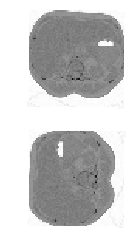

In [25]:
def rotate_image(img,label):
    rotated_img=ndimage.rotate(img, 90)
    #print('label:'+label)
    if label =='1 0 0 0':
        rotated_label='0 1 0 0'
    if label =='0 1 0 0':
        rotated_label='0 0 1 0'
    if label =='0 0 1 0':
        rotated_label='0 0 0 1'
    if label =='0 0 0 1':
        rotated_label='1 0 0 0'
    #print('rotated:'+rotated_label)
    return rotated_img, rotated_label
   

count=0
val_count=0
with open('Capstone\Train_data.txt', 'w') as train_file:
    with open('Capstone\Validation_data','w') as validation_file:
        for f in z.namelist():
            #print(f[:4])
            if f[:4] == 'trai':
                #print(f[:4])
                if f[-4:] == '.png':
                    count += 3
                    img=mpimg.imread(z.open(f))
                    #print(img.shape)
                    img=(img/(np.max(img)/255)).astype(int)
                    imgstr=img.astype(str)
                    label_str = labels[labels_dict[int(f[-10:-4])]]
                    feature_str = ' '.join(imgstr.flatten()[:])
                    train_file.write('|labels {} |features {}\n'.format(label_str,feature_str))
                    img, label_str = rotate_image(img,label_str)
                    imgstr=img.astype(str)
                    feature_str = ' '.join(imgstr.flatten()[:])
                    train_file.write('|labels {} |features {}\n'.format(label_str,feature_str))
                    img, label_str = rotate_image(img,label_str)
                    imgstr=img.astype(str)
                    feature_str = ' '.join(imgstr.flatten()[:])
                    train_file.write('|labels {} |features {}\n'.format(label_str,feature_str))
                    img, label_str = rotate_image(img,label_str)
                    imgstr=img.astype(str)
                    feature_str = ' '.join(imgstr.flatten()[:])
                    validation_file.write('|labels {} |features {}\n'.format(label_str,feature_str))
                    val_count +=1
                    #print(img.flatten())
                    if f[-10:-4]== '100000':
                        print(f)
                        print(label_str)
                        plt.figure(1)
                        plt.subplot(211)
                        plt.imshow(img, cmap="gray_r")
                        plt.axis('off')
                        plt.subplot(212)
                        rotates_img = ndimage.rotate(img, 90)
                        plt.imshow(rotates_img, 'gray_r')
                        plt.axis('off')
print('Exported {} training samples and {} validation samples'.format(count,val_count))

 

def export_test_data():
    count=0
    with open('Capstone\Test_data.txt', 'w') as test_file:
        for f in sorted(z.namelist()):
            #print(f[:4])
            if f[:4] == 'test':
                #print(f[:4])
                if f[-4:] == '.png':
                    img=mpimg.imread(z.open(f))
                    #print(img.shape)
                    img=(img/(np.max(img)/255)).astype(int)
                    imgstr=img.astype(str)
                    label_str ='0 0 0 0'
                    feature_str = ' '.join(imgstr.flatten()[:])
                    #print(feature_str)
                    test_file.write('|labels {} |features {}\n'.format(label_str,feature_str))            
    print('Exported {} training samples'.format(count))

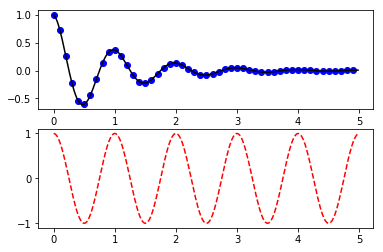

In [17]:
def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

t1 = np.arange(0.0, 5.0, 0.1)
t2 = np.arange(0.0, 5.0, 0.02)

plt.figure(1)
plt.subplot(211)
plt.plot(t1, f(t1), 'bo', t2, f(t2), 'k')

plt.subplot(212)
plt.plot(t2, np.cos(2*np.pi*t2), 'r--')
plt.show()